Importing Libraries

In [6]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from prophet import Prophet
from xgboost import XGBRegressor

Loading Dataset

In [8]:
df1 = pd.read_csv('/content/AEP_hourly.csv', index_col='Datetime')
df2 = pd.read_csv('/content/COMED_hourly.csv', index_col='Datetime')
df3 = pd.read_csv('/content/DAYTON_hourly.csv', index_col='Datetime')
df4 = pd.read_csv('/content/DEOK_hourly.csv', index_col='Datetime')
df5 = pd.read_csv('/content/DOM_hourly.csv', index_col='Datetime')
df6 = pd.read_csv('/content/DUQ_hourly.csv', index_col='Datetime')
df7 = pd.read_csv('/content/EKPC_hourly.csv', index_col='Datetime')
df8 = pd.read_csv('/content/FE_hourly.csv', index_col='Datetime')
df9 = pd.read_csv('/content/NI_hourly.csv', index_col='Datetime')
df10 = pd.read_csv('/content/PJME_hourly.csv', index_col='Datetime')
df11 = pd.read_csv('/content/PJMW_hourly.csv', index_col='Datetime')

# For visualization purpose
df_final = df1.join([df2, df3, df4, df5, df6, df7, df8, df9, df10, df11])

# We only use DAYTON_hourly.csv for modeling later since the approach is the same for each file
df = df3

In [9]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 125361 entries, 2004-10-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   AEP_MW     125361 non-null  float64
 1   COMED_MW   70583 non-null   float64
 2   DAYTON_MW  125361 non-null  float64
 3   DEOK_MW    61825 non-null   float64
 4   DOM_MW     120275 non-null  float64
 5   DUQ_MW     123154 non-null  float64
 6   EKPC_MW    49421 non-null   float64
 7   FE_MW      66960 non-null   float64
 8   NI_MW      54778 non-null   float64
 9   PJME_MW    125361 non-null  float64
 10  PJMW_MW    125361 non-null  float64
dtypes: float64(11)
memory usage: 11.5+ MB


In [10]:
df_final.describe()

,AEP_MW,COMED_MW,DAYTON_MW,DEOK_MW,DOM_MW,DUQ_MW,EKPC_MW,FE_MW,NI_MW,PJME_MW,PJMW_MW
count,125361.000000,70583.000000,125361.000000,61825.000000,120275.000000,123154.000000,49421.000000,66960.000000,54778.000000,125361.000000,125361.000000
mean,15363.077847,11237.756174,2017.668996,3041.597541,10845.028119,1642.043401,1435.357722,7663.627688,11713.761236,31759.038983,5531.513541
std,2661.589281,2357.022834,402.920846,637.299488,2438.253016,310.399093,382.815695,1386.468697,2363.414180,6643.720256,1008.678744
min,9581.000000,7237.000000,982.000000,907.000000,1253.000000,1014.000000,514.000000,0.000000,7003.000000,14544.000000,2553.000000
25%,13416.000000,9496.000000,1716.000000,2594.000000,9154.000000,1423.000000,1153.000000,6608.000000,9981.000000,27103.000000,4788.000000
50%,15206.000000,11018.000000,1994.000000,2971.000000,10402.000000,1618.000000,1365.000000,7606.000000,11530.000000,31182.000000,5447.000000
75%,17121.000000,12397.000000,2267.000000,3409.000000,12287.500000,1811.000000,1667.000000,8483.000000,12891.000000,35451.000000,6199.000000
max,25695.000000,23753.000000,3746.000000,5445.000000,21651.000000,3054.000000,3490.000000,14032.000000,23631.000000,62009.000000,9594.000000


Data Transformation and EDA

Text(0.5, 1.0, 'PJM Energy Cosumption')

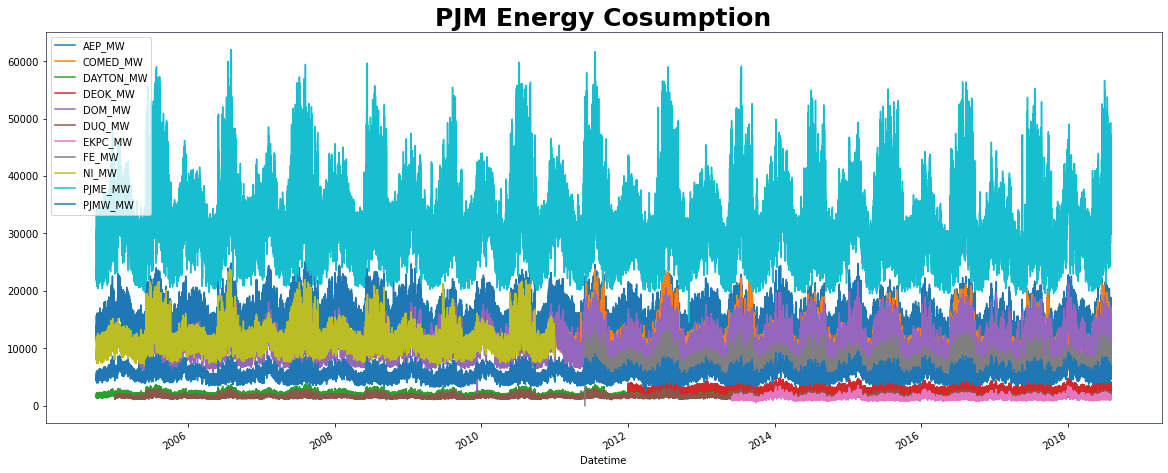

In [11]:
df_final.index = pd.to_datetime(df_final.index)

df_final.plot(figsize=(20,8))
plt.title('PJM Energy Cosumption', weight='bold', fontsize=25)

Text(0.5, 1.0, 'PJM Energy Cosumption\nfrom 2018-01-01 to 2018-01-08')

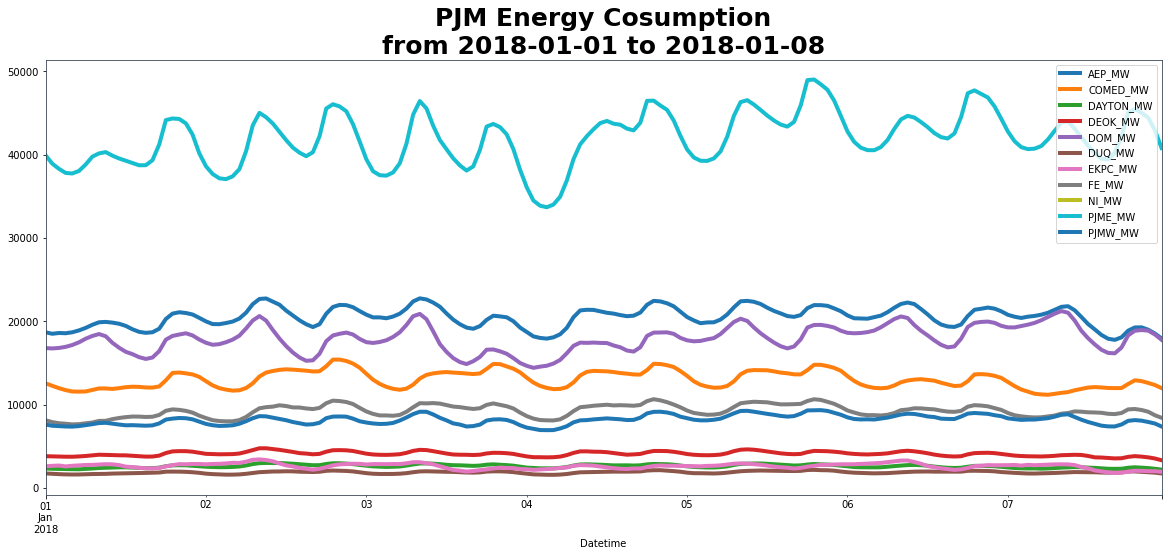

In [12]:
df_2018 = df_final[(df_final.index >= '2018-01-01') & (df_final.index < '2018-01-08')]

df_2018.plot(figsize=(20,8), lw=4)
plt.title('PJM Energy Cosumption\nfrom 2018-01-01 to 2018-01-08', weight='bold', fontsize=25)

In [13]:
df_final['Hour'] = df_final.index.hour
df_final['Day'] = df_final.index.day
df_final['Month'] = df_final.index.month
df_final['Quarter'] = df_final.index.quarter
df_final['Year'] = df_final.index.year

df_final.head(3)

,AEP_MW,COMED_MW,DAYTON_MW,DEOK_MW,DOM_MW,DUQ_MW,EKPC_MW,FE_MW,NI_MW,PJME_MW,PJMW_MW,Hour,Day,Month,Quarter,Year
Datetime,,,,,,,,,,,,,,,,
2004-10-01 01:00:00,12379.0,NaN,1621.0,NaN,NaN,NaN,NaN,NaN,9305.0,24025.0,4628.0,1,1,10,4,2004
2004-10-01 02:00:00,11935.0,NaN,1536.0,NaN,NaN,NaN,NaN,NaN,8681.0,22845.0,4520.0,2,1,10,4,2004
2004-10-01 03:00:00,11692.0,NaN,1500.0,NaN,NaN,NaN,NaN,NaN,8314.0,22138.0,4431.0,3,1,10,4,2004


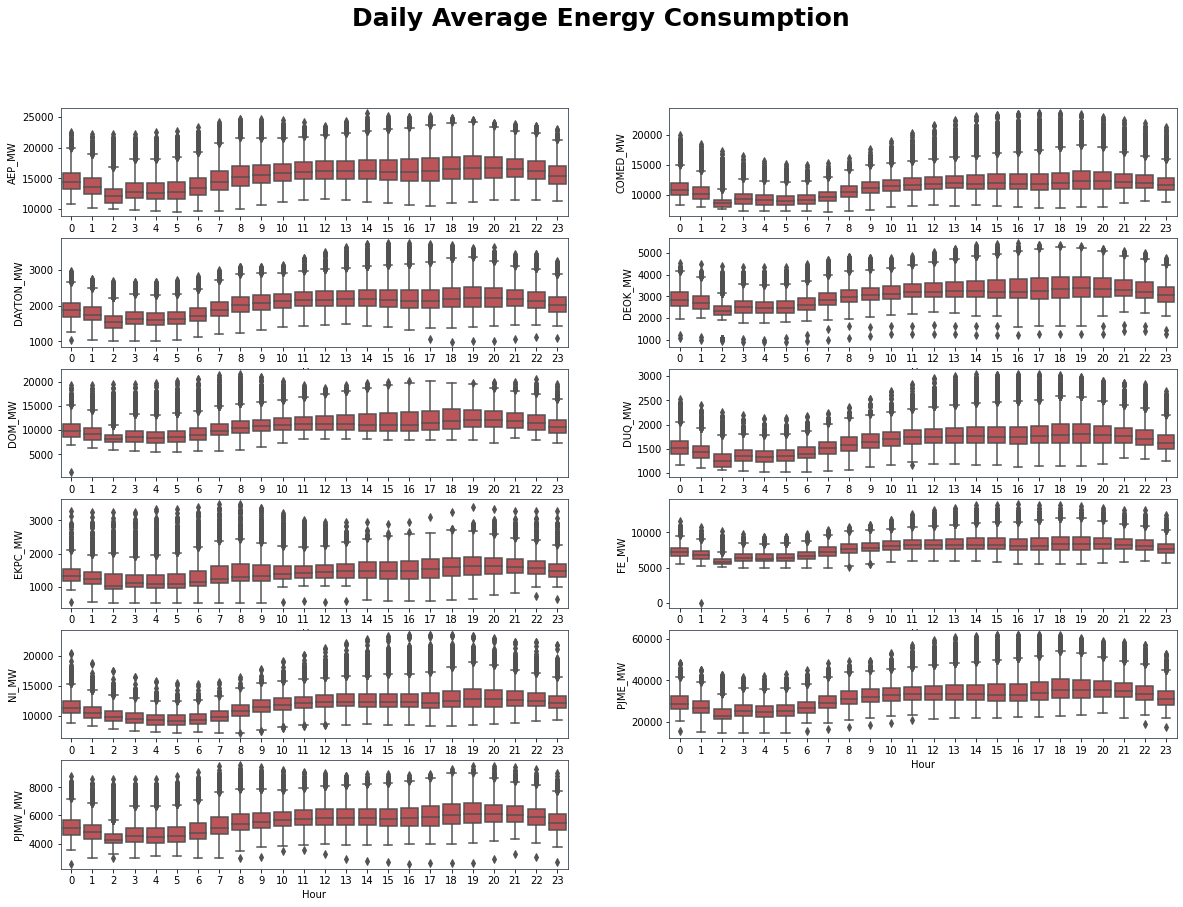

In [14]:
columns = ['AEP_MW', 'COMED_MW', 'DAYTON_MW', 'DEOK_MW', 'DOM_MW', 'DUQ_MW',
           'EKPC_MW', 'FE_MW', 'NI_MW', 'PJME_MW', 'PJMW_MW']

f, axes = plt.subplots(nrows=6, ncols=2, figsize=(20, 14))
f.suptitle('Daily Average Energy Consumption', weight='bold', fontsize=25)
# We just need 11 figures, so we delete the last one
f.delaxes(axes[5][1])

for i, col in enumerate(columns):
    sns.boxplot(data=df_final, x='Hour', y=col, ax=axes.flatten()[i], color='#cc444b')

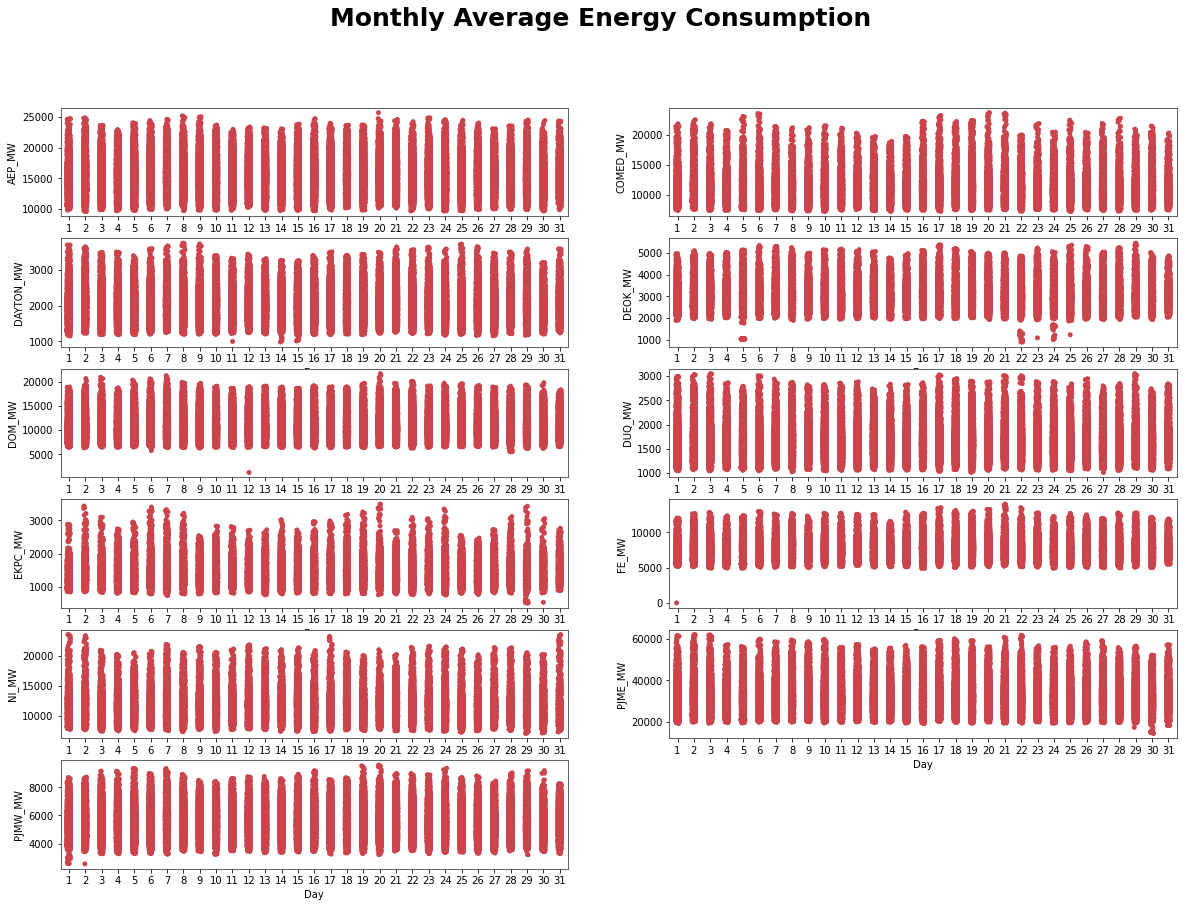

In [15]:
f, axes = plt.subplots(nrows=6, ncols=2, figsize=(20, 14))
f.suptitle('Monthly Average Energy Consumption', weight='bold', fontsize=25)
# We just need 11 figures, so we delete the last one
f.delaxes(axes[5][1])

for i, col in enumerate(columns):
    sns.stripplot(data=df_final, x='Day', y=col, ax=axes.flatten()[i], color='#cc444b')

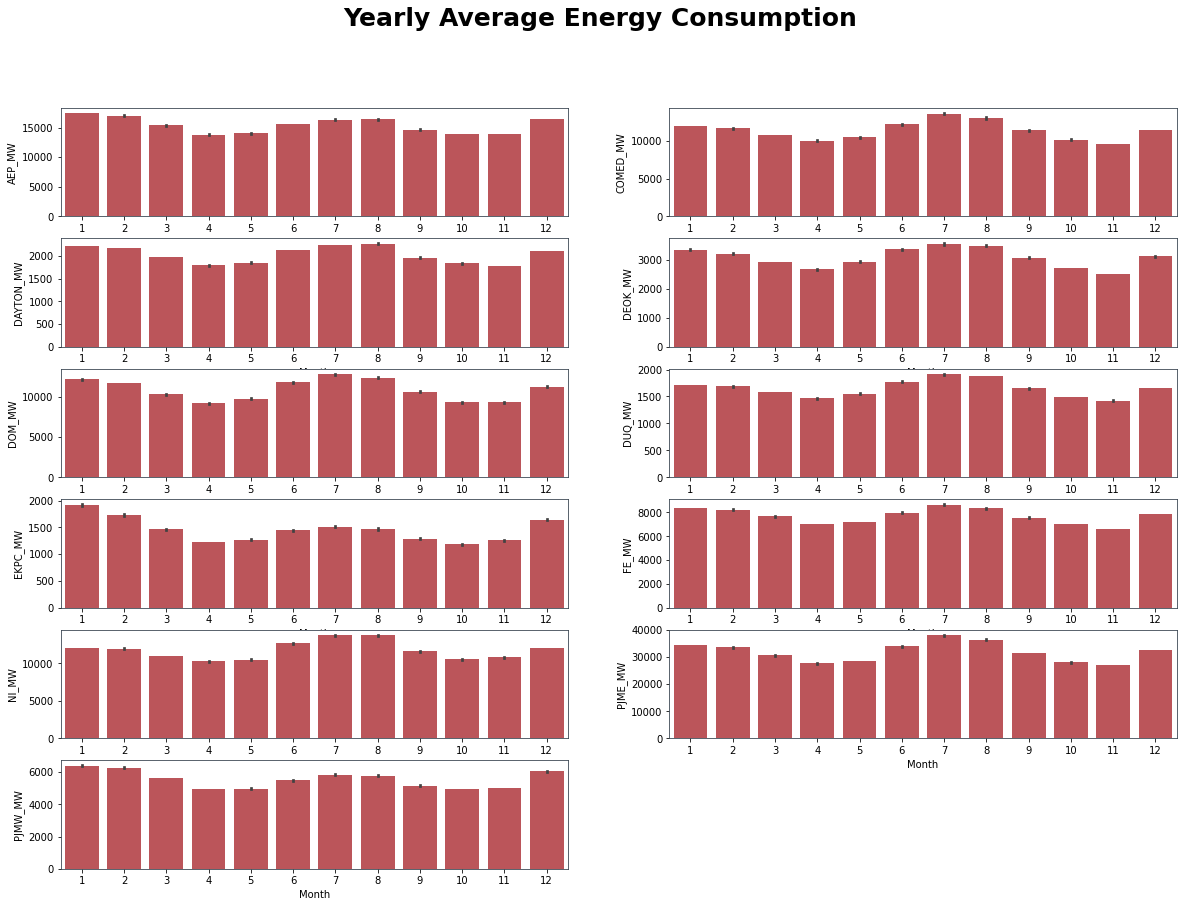

In [16]:
f, axes = plt.subplots(nrows=6, ncols=2, figsize=(20, 14))
f.suptitle('Yearly Average Energy Consumption', weight='bold', fontsize=25)
# We just need 11 figures, so we delete the last one
f.delaxes(axes[5][1])

for i, col in enumerate(columns):
    sns.barplot(data=df_final, x='Month', y=col, ax=axes.flatten()[i], color='#cc444b')

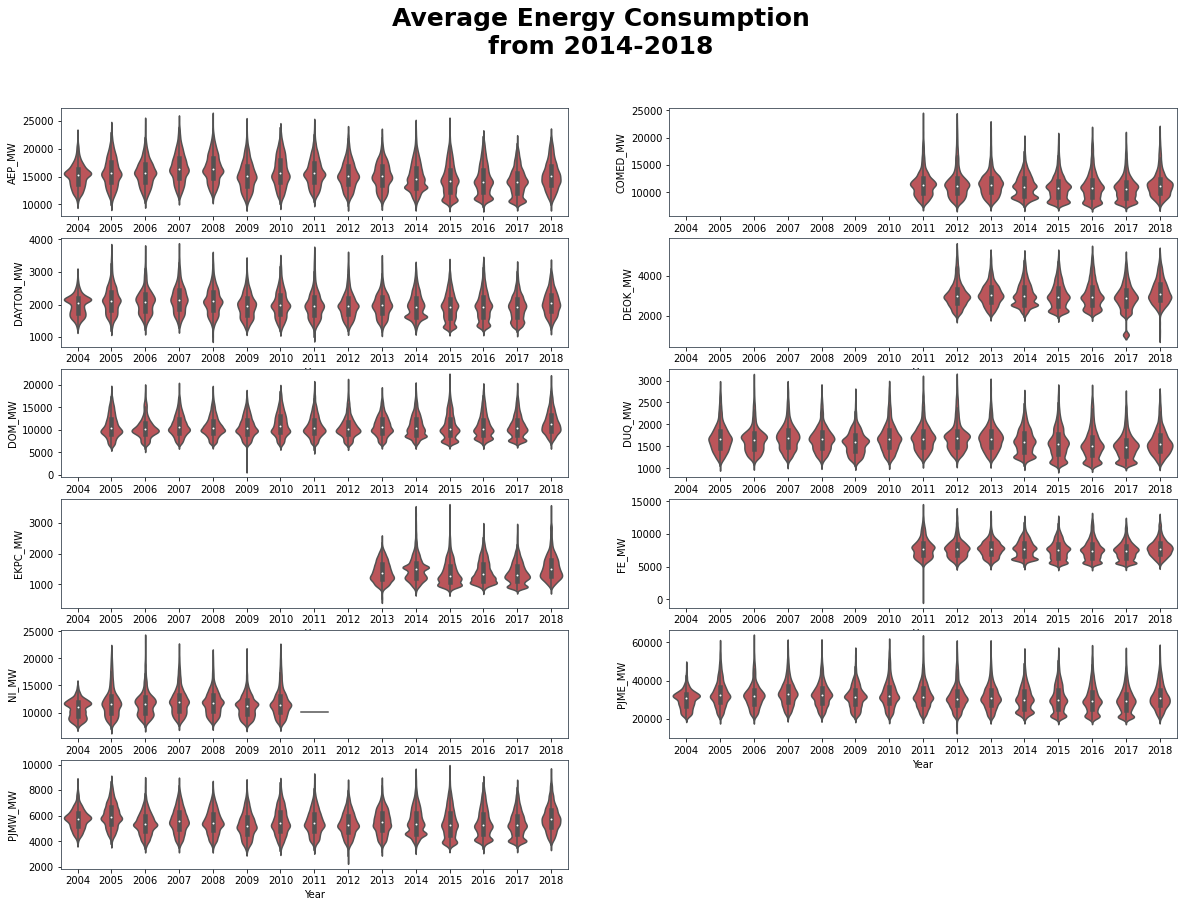

In [17]:
f, axes = plt.subplots(nrows=6, ncols=2, figsize=(20, 14))
f.suptitle('Average Energy Consumption\nfrom 2014-2018', weight='bold', fontsize=25)
# We just need 11 figures, so we delete the last one
f.delaxes(axes[5][1])

for i, col in enumerate(columns):
    sns.violinplot(data=df_final, x='Year', y=col, ax=axes.flatten()[i], color='#cc444b')

In [18]:
# Set color style
plt.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=['#cc444b', '#e89005'])

In [19]:
df.index = pd.to_datetime(df.index)
df = df.sort_index()

# The data that we are going to use (DAYTON)
df.head()

,DAYTON_MW
Datetime,
2004-10-01 01:00:00,1621.0
2004-10-01 02:00:00,1536.0
2004-10-01 03:00:00,1500.0
2004-10-01 04:00:00,1434.0
2004-10-01 05:00:00,1489.0


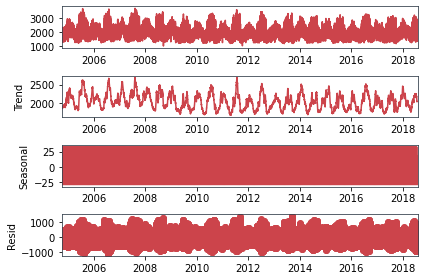

In [20]:
seasonal_decompose(df, period=365).plot()
plt.show()

In [21]:
# Daily Consumption
ma = df.resample('D').mean()

# 3 Day Example
ma['Moving Average'] = ma['DAYTON_MW'].rolling(3).mean()
ma.head()

,DAYTON_MW,Moving Average
Datetime,,
2004-10-01,1924.130435,NaN
2004-10-02,1641.583333,NaN
2004-10-03,1528.708333,1698.140700
2004-10-04,1926.541667,1698.944444
2004-10-05,1970.125000,1808.458333


In [22]:
def moving_average(data, window):
    data['Moving Average'] = data['DAYTON_MW'].rolling(window).mean()
    actual = data['DAYTON_MW'][-(window+30):]
    ma = data['Moving Average'][-(window+30):]
    
    plt.figure(figsize=(20,8))
    actual.plot(label='Actual', lw=4)
    ma.plot(label='MA-{}'.format(str(window)), ls='--', lw=2)
    plt.title('{}-Days Moving Average'.format(str(window)), weight='bold', fontsize=25)
    plt.legend()

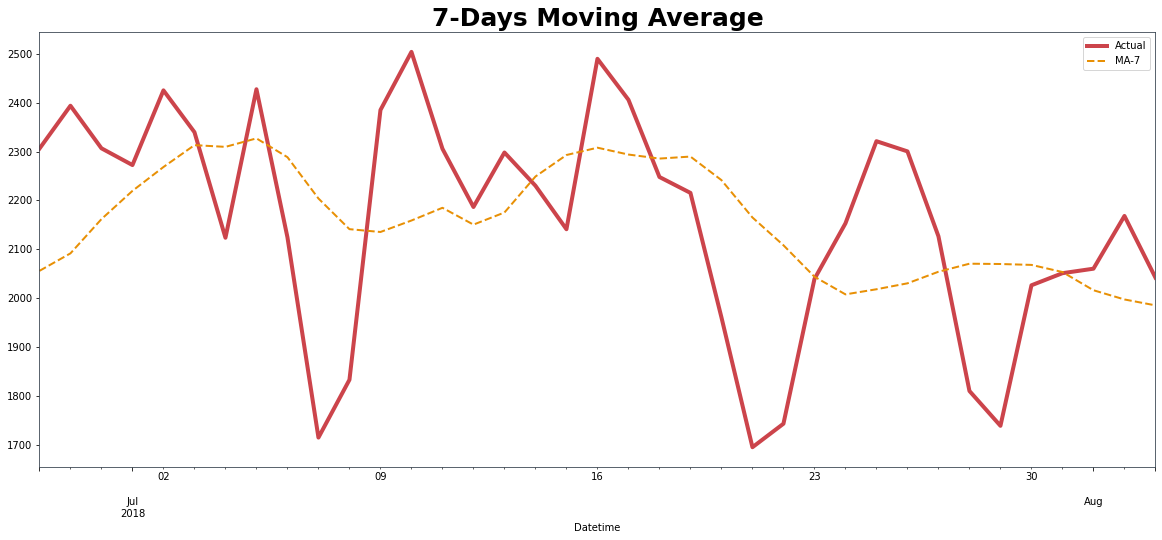

In [23]:
moving_average(ma, 7)

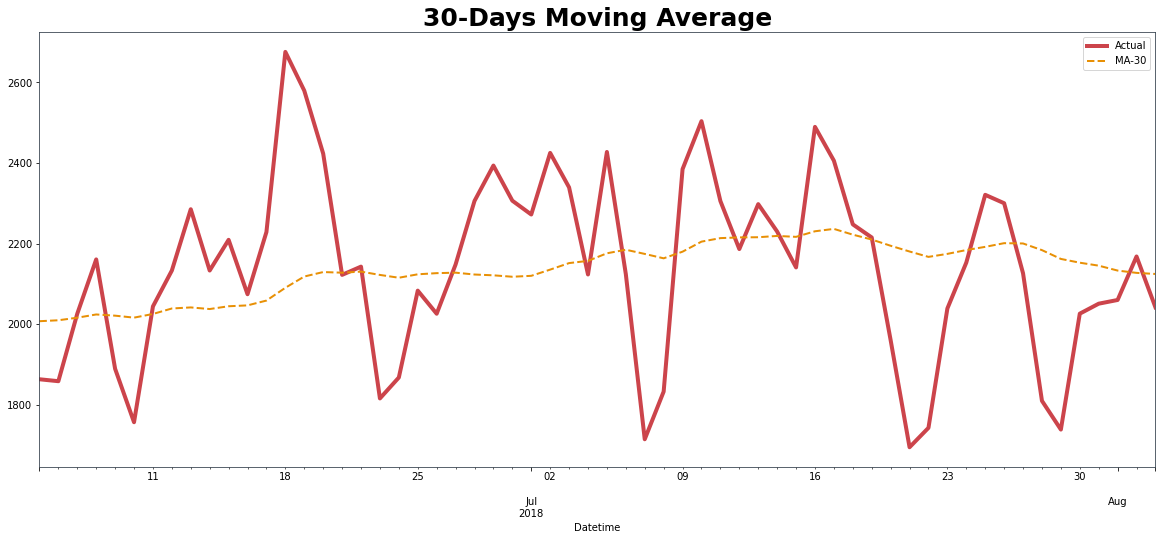

In [24]:
moving_average(ma, 30)

In [25]:
# Before building and training our model, let's split the data into training and testing
df_train, df_test = df[df.index < '2016-01-01'], df[df.index >= '2016-01-01']

print('Train:\t', len(df_train))
print('Test:\t', len(df_test))

Train:	 98595
Test:	 22680


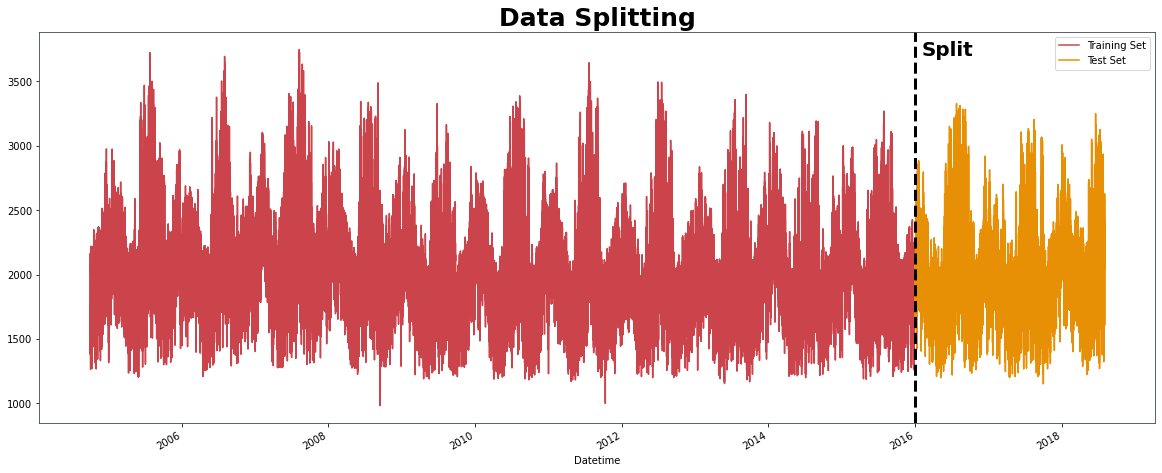

In [26]:
plt.figure(figsize=(20,8))

df_train['DAYTON_MW'].plot(label='Training Set')
df_test['DAYTON_MW'].plot(label='Test Set')
plt.axvline('2016-01-01', color='black', ls='--', lw=3)
plt.text('2016-02-01', 3700, 'Split', fontsize=20, fontweight='bold')
plt.title('Data Splitting', weight='bold', fontsize=25)
plt.legend()

Building Models
1. Prophet

In [27]:
def index_to_column(data):
    data = data.reset_index()
    data['Datetime'] = pd.to_datetime(data['Datetime'])
    data = data.sort_values('Datetime')
    
    data = data.rename(columns={'Datetime': 'ds', 'DAYTON_MW': 'y'})
    return data

In [28]:
prophet_train = index_to_column(df_train)
prophet_test = index_to_column(df_test)

In [29]:
prophet_model = Prophet(interval_width=0.95)

prophet_model.fit(prophet_train)
prophet_pred = prophet_model.predict(prophet_test[['ds']]) # Keep the dataset format

DEBUG:cmdstanpy:input tempfile: /tmp/tmpk14ffkzr/fhcaahyb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk14ffkzr/h2k0fqez.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81758', 'data', 'file=/tmp/tmpk14ffkzr/fhcaahyb.json', 'init=/tmp/tmpk14ffkzr/h2k0fqez.json', 'output', 'file=/tmp/tmpk14ffkzr/prophet_model4smtxien/prophet_model-20230301161255.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:12:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:15:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


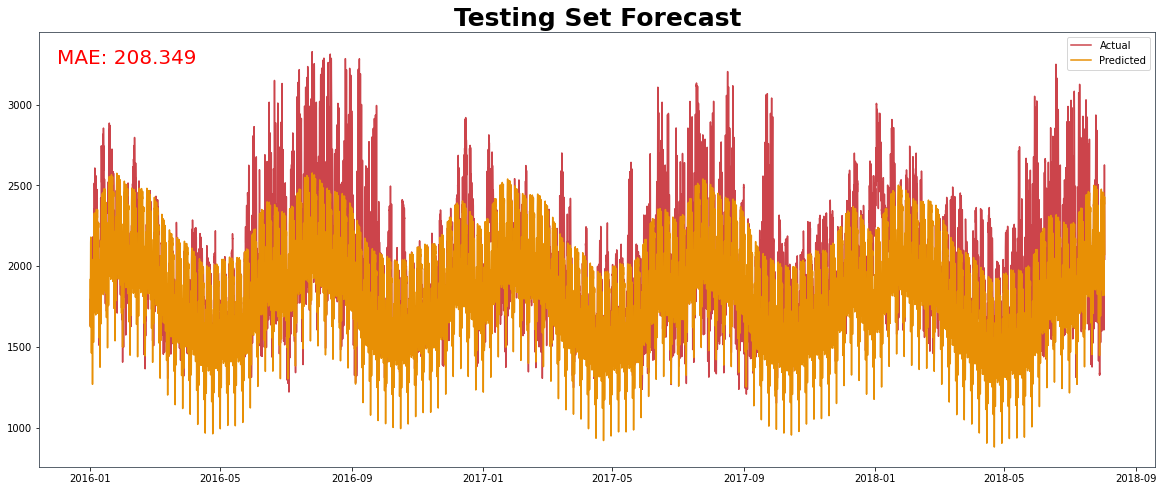

In [30]:
mae = round(mean_absolute_error(prophet_test['y'], prophet_pred['yhat']), 3)

plt.figure(figsize=(20,8))
plt.plot(prophet_test['ds'], prophet_test['y'], label='Actual')
plt.plot(prophet_pred['ds'], prophet_pred['yhat'], label='Predicted')
plt.title('Test Forecasting', weight='bold', fontsize=40)
plt.text(16770, 3250, 'MAE: {}'.format(mae), fontsize=20, color='red')
plt.title('Testing Set Forecast', weight='bold', fontsize=25)
plt.legend()

Predict the value for next 7 days

In [31]:
# This time, we will use all data (train and test) to train our model
new_df = index_to_column(df)

In [32]:
prophet_model2 = Prophet(interval_width=0.95)
prophet_model2.fit(new_df)
# 7 days to the future (7x24 = 168)
future_dates = prophet_model2.make_future_dataframe(periods=168, freq='H')
prophet_pred2 = prophet_model2.predict(future_dates)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpk14ffkzr/p12b5i_p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk14ffkzr/9aa1agdl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23283', 'data', 'file=/tmp/tmpk14ffkzr/p12b5i_p.json', 'init=/tmp/tmpk14ffkzr/9aa1agdl.json', 'output', 'file=/tmp/tmpk14ffkzr/prophet_modelqfpx4mh7/prophet_model-20230301161612.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:16:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:18:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


<Figure size 1440x576 with 0 Axes>

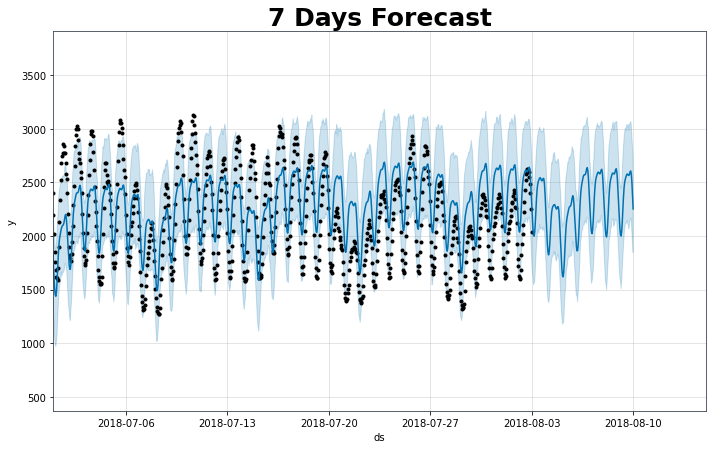

In [33]:
plt.figure(figsize=(20,8))

fig = prophet_model2.plot(prophet_pred2, uncertainty=True)
ax = fig.gca()
ax.set_xlim(pd.to_datetime(['2018-07-01', '2018-08-15']))
plt.title('7 Days Forecast', weight='bold', fontsize=25)
plt.show()

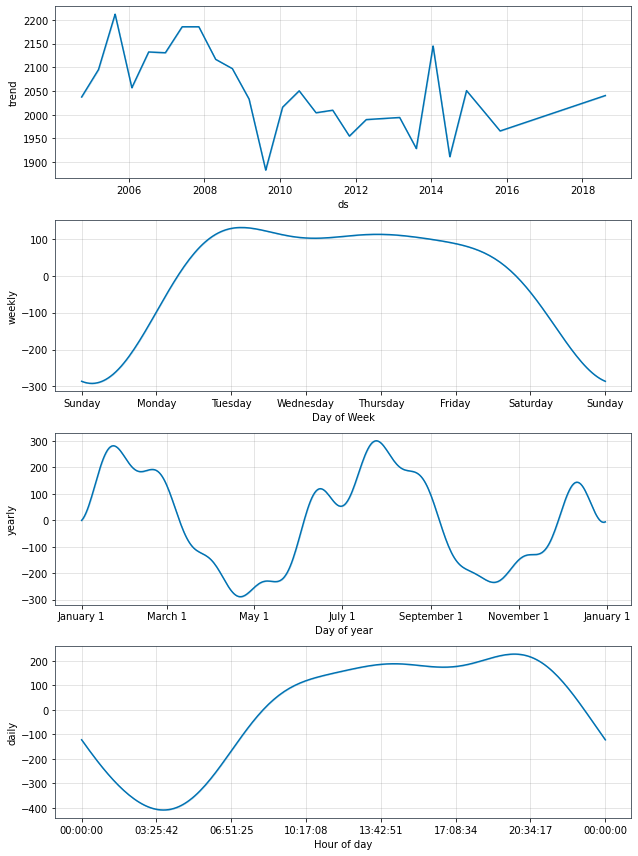

In [34]:
prophet_model.plot_components(prophet_pred2)
plt.show()

<Figure size 1440x576 with 0 Axes>

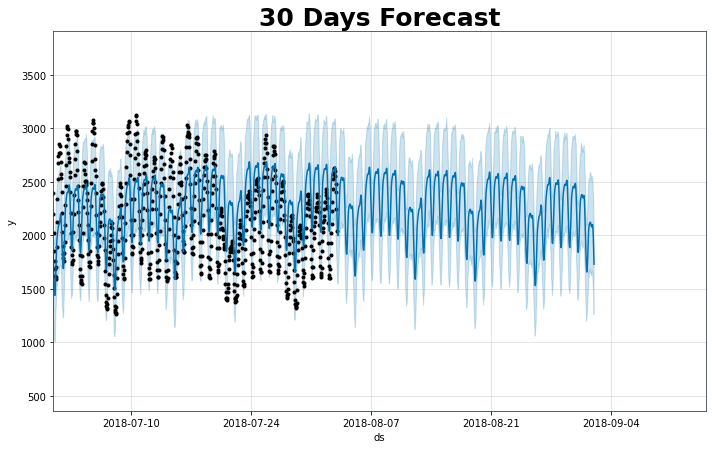

In [35]:
future_dates2 = prophet_model2.make_future_dataframe(periods=720, freq='H')
prophet_pred3 = prophet_model2.predict(future_dates2)

plt.figure(figsize=(20,8))

fig = prophet_model2.plot(prophet_pred3, uncertainty=True)
ax = fig.gca()
ax.set_xlim(pd.to_datetime(['2018-07-01', '2018-09-15']))
plt.title('30 Days Forecast', weight='bold', fontsize=25)
plt.show()

2. XGBoost

In [36]:
def date_transform(data):
    df = data.copy()
    
    df['Hour'] = df.index.hour
    df['Dayofweek'] = df.index.dayofweek
    df['Dayofmonth'] = df.index.day
    df['Dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.weekofyear
    df['Month'] = df.index.month
    df['Quarter'] = df.index.quarter
    df['Year'] = df.index.year
    
    X = df.drop('DAYTON_MW', axis=1)
    y = df['DAYTON_MW']
    
    return X, y

In [37]:
X_train, y_train = date_transform(df_train)
X_test, y_test = date_transform(df_test)

<ipython-input-36-5e9958b18cb3>:8: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['weekofyear'] = df.index.weekofyear


In [38]:
xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, early_stopping_rounds=10)
xgb_model.fit(X_train, y_train, eval_metric='mae', eval_set=[(X_train, y_train), (X_test, y_test)])
xgb_pred = xgb_model.predict(X_test)

[0]	validation_0-mae:1940.29813	validation_1-mae:1914.34630
[1]	validation_0-mae:1843.33246	validation_1-mae:1818.57857


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-mae:1751.21403	validation_1-mae:1727.56571
[3]	validation_0-mae:1663.69971	validation_1-mae:1639.56677
[4]	validation_0-mae:1580.55842	validation_1-mae:1557.33410
[5]	validation_0-mae:1501.57253	validation_1-mae:1478.38449
[6]	validation_0-mae:1426.53517	validation_1-mae:1403.89960
[7]	validation_0-mae:1355.24711	validation_1-mae:1333.48977
[8]	validation_0-mae:1287.52372	validation_1-mae:1266.99870
[9]	validation_0-mae:1223.18415	validation_1-mae:1203.29710
[10]	validation_0-mae:1162.06097	validation_1-mae:1142.84372
[11]	validation_0-mae:1103.99054	validation_1-mae:1086.01553
[12]	validation_0-mae:1048.82219	validation_1-mae:1031.40206
[13]	validation_0-mae:996.41269	validation_1-mae:980.22963
[14]	validation_0-mae:946.62204	validation_1-mae:930.97670
[15]	validation_0-mae:899.32044	validation_1-mae:884.13578
[16]	validation_0-mae:854.38784	validation_1-mae:839.45818
[17]	validation_0-mae:811.70330	validation_1-mae:797.23157
[18]	validation_0-mae:771.15960	validation

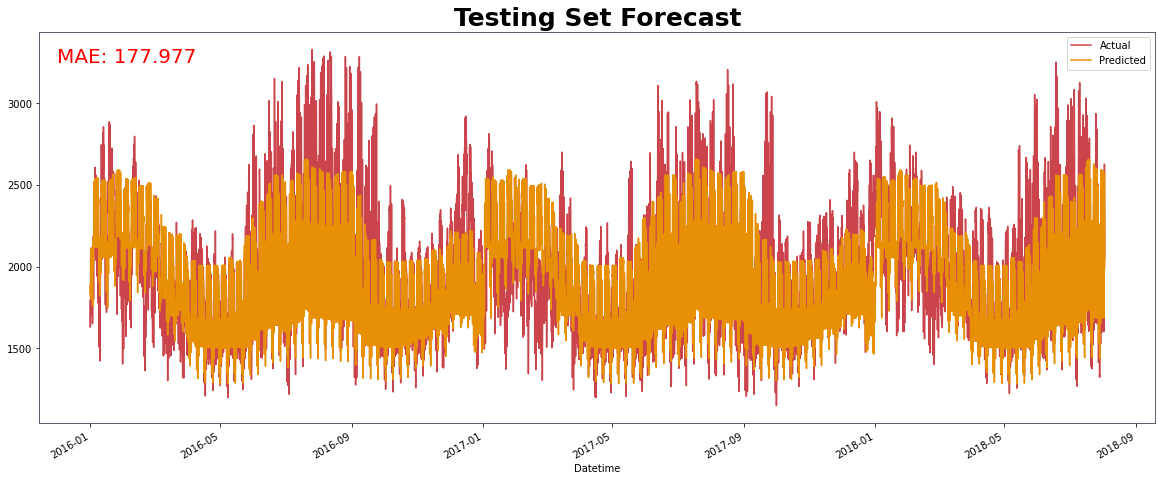

In [39]:
mae = round(mean_absolute_error(y_test, xgb_pred), 3)

df_plot = pd.DataFrame({'y_test':y_test, 'xgb_pred':xgb_pred})

plt.figure(figsize=(20,8))

df_plot['y_test'].plot(label='Actual')
df_plot['xgb_pred'].plot(label='Predicted')
plt.text(16770, 3250, 'MAE: {}'.format(mae), fontsize=20, color='red')
plt.title('Testing Set Forecast', weight='bold', fontsize=25)
plt.legend()
plt.show()

Predict the value for next 7 days

In [40]:
future_dates2 = future_dates.iloc[-168:, :].copy()

future_dates2['ds'] = pd.to_datetime(future_dates2['ds'])
future_dates2 = future_dates2.set_index('ds')

future_dates2['Hour'] = future_dates2.index.hour
future_dates2['Dayofweek'] = future_dates2.index.dayofweek
future_dates2['Dayofmonth'] = future_dates2.index.day
future_dates2['Dayofyear'] = future_dates2.index.dayofyear
future_dates2['weekofyear'] = future_dates2.index.weekofyear
future_dates2['Month'] = future_dates2.index.month
future_dates2['Quarter'] = future_dates2.index.quarter
future_dates2['Year'] = future_dates2.index.year

<ipython-input-40-1ca5ee7d46d7>:10: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  future_dates2['weekofyear'] = future_dates2.index.weekofyear


In [41]:
X = pd.concat([X_train, X_test], ignore_index=True)
y = pd.concat([y_train, y_test], ignore_index=True)

In [42]:
xgb_model2 = XGBRegressor(n_estimators=1000, learning_rate=0.05)
xgb_model2.fit(X, y, eval_metric='mae')
xgb_pred2 = xgb_model2.predict(future_dates2)

/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


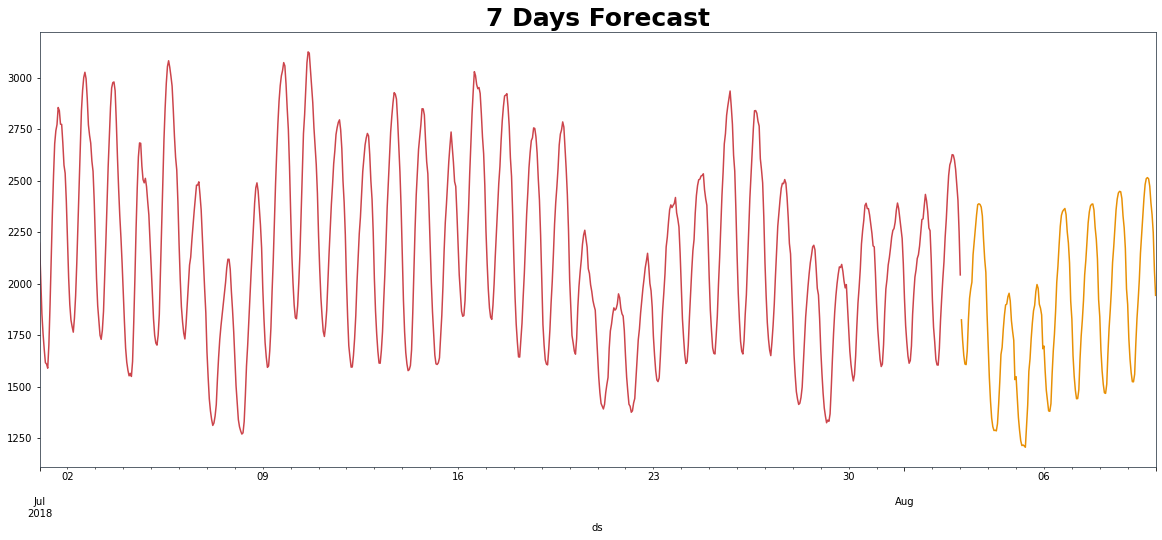

In [43]:
df_plot2 = pd.DataFrame({'Hour':future_dates2['Hour'], 'xgb_pred2':xgb_pred2})

last_week = df['2018-07-01':'2018-08-15']

plt.figure(figsize=(20,8))

last_week['DAYTON_MW'].plot()
df_plot2['xgb_pred2'].plot()
plt.title('7 Days Forecast', weight='bold', fontsize=25)
plt.show()

<ipython-input-44-16234dbeb9f7>:11: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  future_dates3['weekofyear'] = future_dates3.index.weekofyear
/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


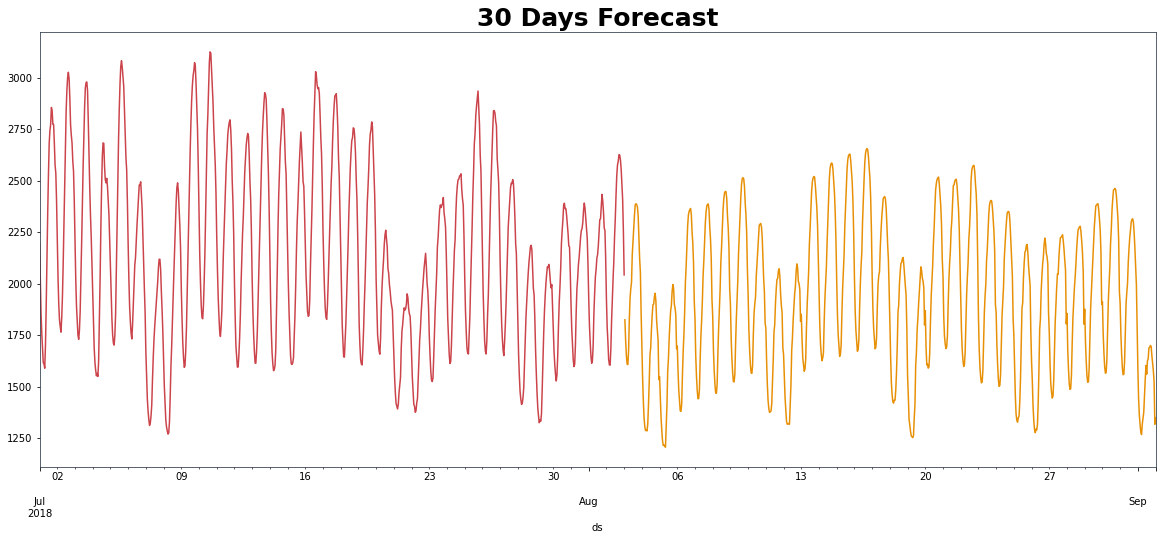

In [44]:
a = prophet_model2.make_future_dataframe(periods=720, freq='H')
future_dates3 = a.iloc[-720:, :].copy()

future_dates3['ds'] = pd.to_datetime(future_dates3['ds'])
future_dates3 = future_dates3.set_index('ds')

future_dates3['Hour'] = future_dates3.index.hour
future_dates3['Dayofweek'] = future_dates3.index.dayofweek
future_dates3['Dayofmonth'] = future_dates3.index.day
future_dates3['Dayofyear'] = future_dates3.index.dayofyear
future_dates3['weekofyear'] = future_dates3.index.weekofyear
future_dates3['Month'] = future_dates3.index.month
future_dates3['Quarter'] = future_dates3.index.quarter
future_dates3['Year'] = future_dates3.index.year

Xx = pd.concat([X_train, X_test], ignore_index=True)
yy = pd.concat([y_train, y_test], ignore_index=True)

xgb_model3 = XGBRegressor(n_estimators=1000, learning_rate=0.05)
xgb_model3.fit(Xx, yy, eval_metric='mae')
xgb_pred3 = xgb_model3.predict(future_dates3)

df_plot3 = pd.DataFrame({'Hour':future_dates3['Hour'], 'xgb_pred2':xgb_pred3})

last_week3 = df['2018-07-01':'2018-08-15']

plt.figure(figsize=(20,8))

last_week3['DAYTON_MW'].plot()
df_plot3['xgb_pred2'].plot()
plt.title('30 Days Forecast', weight='bold', fontsize=25)
plt.show()

3. Deep Neural Network

In [45]:
# EXAMPLE

dataset = tf.expand_dims(df_train['DAYTON_MW'].head(10), axis=-1)

# Generate a tf dataset with 10 elements (i.e. numbers 0 to 9)
dataset = tf.data.Dataset.from_tensor_slices(dataset)

# Window the data but only take those with the specified size
dataset = dataset.window(5, shift=1, drop_remainder=True)

# Flatten the windows by putting its elements in a single batch
dataset = dataset.flat_map(lambda window: window.batch(5))

# Create tuples with features (first four elements of the window) and labels (last element)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))

# # Shuffle the windows
# dataset = dataset.shuffle(buffer_size=10)

# # Create batches of windows
# dataset = dataset.batch(2).prefetch(1)

# Print the results
for x,y in dataset:
    print("x = ", x.numpy())
    print("y = ", y.numpy())
    print()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


x =  [[1621.]
 [1536.]
 [1500.]
 [1434.]]
y =  [1489.]

x =  [[1536.]
 [1500.]
 [1434.]
 [1489.]]
y =  [1620.]

x =  [[1500.]
 [1434.]
 [1489.]
 [1620.]]
y =  [1859.]

x =  [[1434.]
 [1489.]
 [1620.]
 [1859.]]
y =  [2007.]

x =  [[1489.]
 [1620.]
 [1859.]
 [2007.]]
y =  [2025.]

x =  [[1620.]
 [1859.]
 [2007.]
 [2025.]]
y =  [2067.]



In [46]:
def windowing(data, window_size, shuffle_buffer, batch_size):
    dataset = tf.expand_dims(data, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(dataset)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True) # window size = 24 + 1 (test)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1])) # (train, test) 
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [47]:
train = windowing(df_train['DAYTON_MW'], 24, 72, 32)
test = windowing(df_test['DAYTON_MW'], 24, 72, 32)

In [48]:
dnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=16, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[24,1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='relu')),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(1)
])

dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 24, 16)            64        
                                                                 
 bidirectional (Bidirectiona  (None, 32)               4224      
 l)                                                              
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 4,833
Trainable params: 4,833
Non-trainable params: 0
_________________________________________________________________


In [49]:
dnn_model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
dnn_model.fit(train, validation_data=test, epochs=20)

Epoch 1/20
3081/3081 [==============================] - 115s 36ms/step - loss: 150.9345 - val_loss: 77.8198
Epoch 2/20
3081/3081 [==============================] - 93s 30ms/step - loss: 49.2965 - val_loss: 50.8356
Epoch 3/20
3081/3081 [==============================] - 105s 34ms/step - loss: 37.2227 - val_loss: 35.5704
Epoch 4/20
3081/3081 [==============================] - 93s 30ms/step - loss: 34.0387 - val_loss: 32.7129
Epoch 5/20
3081/3081 [==============================] - 93s 30ms/step - loss: 31.6414 - val_loss: 27.4622
Epoch 6/20
3081/3081 [==============================] - 92s 30ms/step - loss: 30.6259 - val_loss: 26.1326
Epoch 7/20
3081/3081 [==============================] - 94s 30ms/step - loss: 29.8932 - val_loss: 24.9769
Epoch 8/20
3081/3081 [==============================] - 90s 29ms/step - loss: 29.5851 - val_loss: 25.9268
Epoch 9/20
3081/3081 [==============================] - 92s 30ms/step - loss: 28.6851 - val_loss: 24.5424
Epoch 10/20
3081/3081 [====================

<AxesSubplot:>

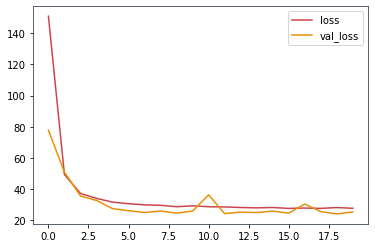

In [50]:
metric = pd.DataFrame(dnn_model.history.history)
metric.plot()

In [51]:
window_size = 24
forecast = []

train_length = len(df_train)
forecast_series = df[train_length - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
    forecast.append(dnn_model.predict(np.expand_dims(forecast_series[time:time + window_size], axis=-1)[np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 39ms/step


<ipython-input-52-2ac30873f11c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Pred'] = results


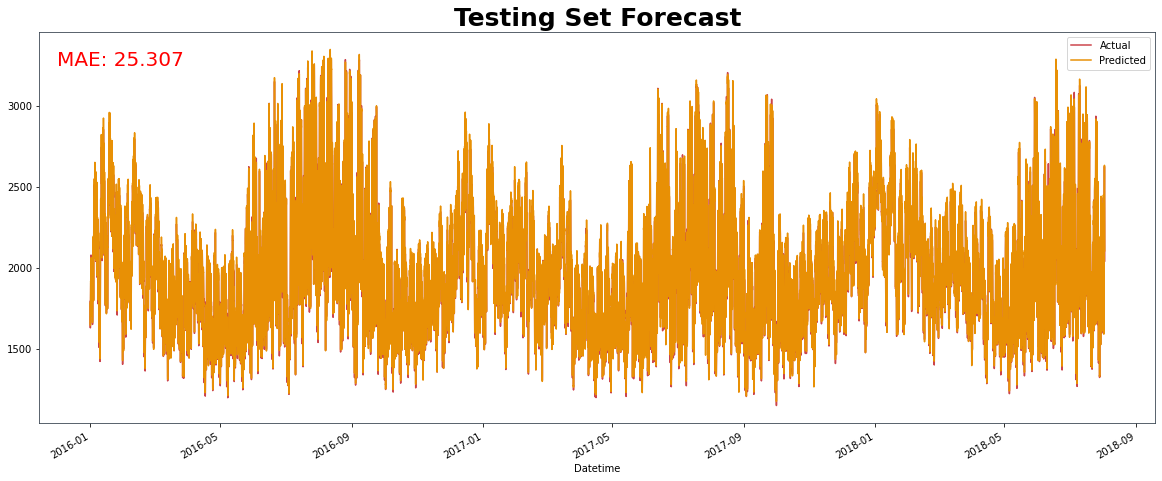

In [52]:
df_test['Pred'] = results

mae = round(mean_absolute_error(df_test['DAYTON_MW'], df_test['Pred']), 3)

plt.figure(figsize=(20,8))

df_test['DAYTON_MW'].plot(label='Actual')
df_test['Pred'].plot(label='Predicted')
plt.text(16770, 3250, 'MAE: {}'.format(mae), fontsize=20, color='red')
plt.title('Testing Set Forecast', weight='bold', fontsize=25)
plt.legend()
plt.show()

In [53]:
window_size = 24

df_forecast = df_test[['Pred']][-24:]
last_date = df_forecast.index

for time in range(168): # 7 days ahead
    pred = dnn_model.predict(np.expand_dims(df_forecast[time:time + window_size], axis=-1)[np.newaxis])[0][0]
    df_forecast = df_forecast.append({'Pred':pred}, ignore_index=True)
    
date_index = pd.date_range('2018-08-02 01:00:00', periods=192, freq='H') # 24+168
df_forecast.set_index(date_index, inplace=True)

1/1 [==============================] - 0s 42ms/step


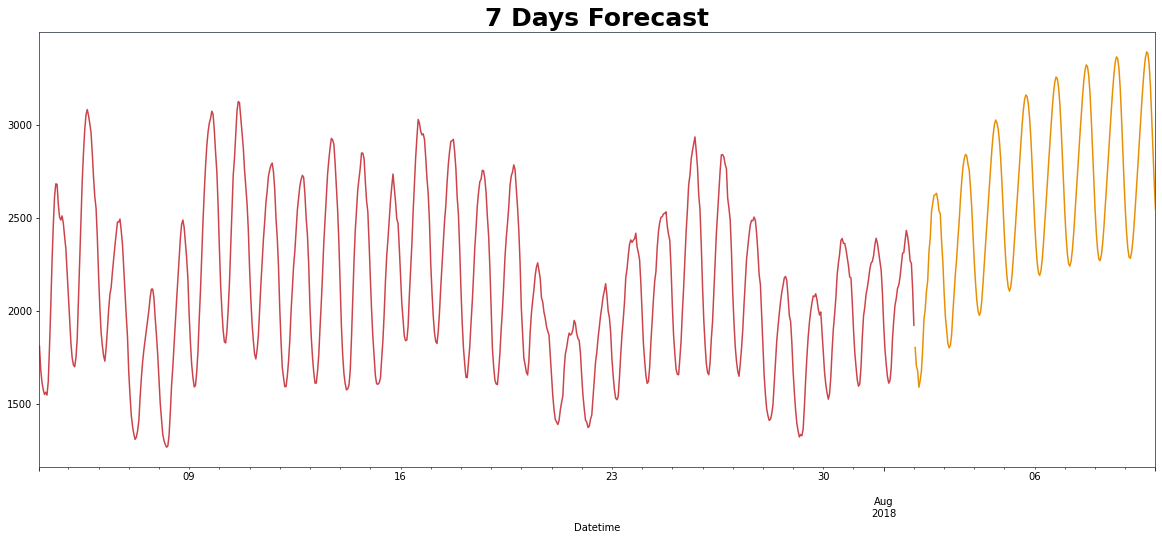

In [54]:
plt.figure(figsize=(20,8))

df_test['DAYTON_MW'][-720:-24].plot()
df_forecast['Pred'].plot()
plt.title('7 Days Forecast', weight='bold', fontsize=25)
plt.show()

1/1 [==============================] - 0s 24ms/step


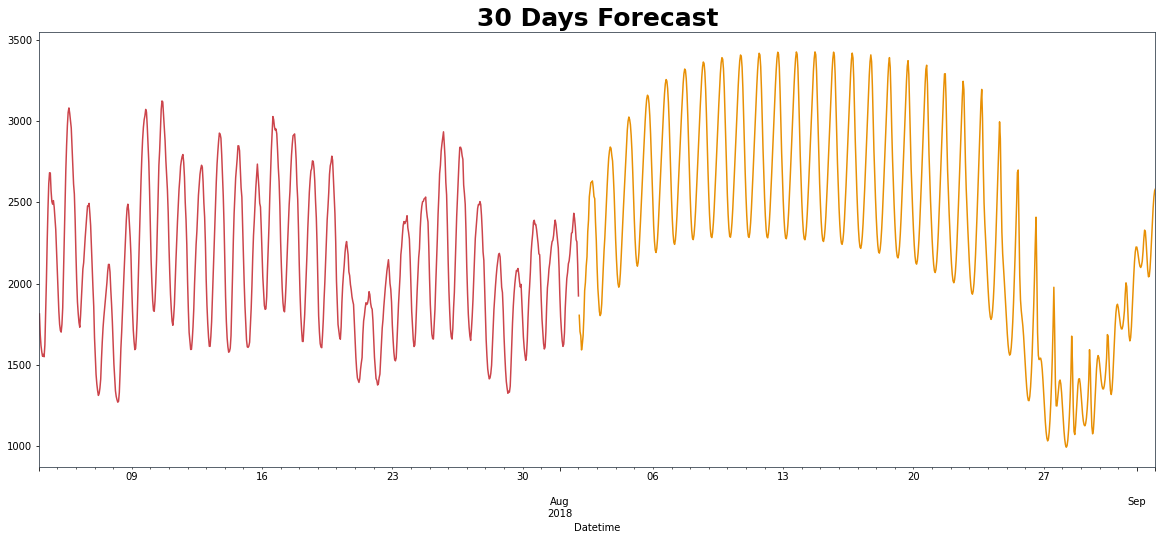

In [55]:
window_size = 24

df_forecast = df_test[['Pred']][-24:]
last_date = df_forecast.index

for time in range(720): # 7 days ahead
    pred = dnn_model.predict(np.expand_dims(df_forecast[time:time + window_size], axis=-1)[np.newaxis])[0][0]
    df_forecast = df_forecast.append({'Pred':pred}, ignore_index=True)
    
date_index = pd.date_range('2018-08-02 01:00:00', periods=744, freq='H') # 24+720
df_forecast.set_index(date_index, inplace=True)

plt.figure(figsize=(20,8))

df_test['DAYTON_MW'][-720:-24].plot()
df_forecast['Pred'].plot()
plt.title('30 Days Forecast', weight='bold', fontsize=25)
plt.show()